<a href="https://colab.research.google.com/github/NayanKanaparthi/Sarcasm-Detection/blob/main/NewsHeadlines_Sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#!pip install tensorflow
#!pip install keras|

In [2]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 10000
embedding_dim =16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = "<OOV>"
training_size = 20000

In [4]:
import json

datastore = []
with open("/content/drive/MyDrive/Machine learning/NLP/Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
    for line in f:
        datastore.append(json.loads(line))

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])



In [5]:
training_sentences= sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

training_padded= pad_sequences(training_sequences, maxlen= max_length, padding= padding_type,truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen= max_length, padding= padding_type,truncating=trunc_type)
# labels are 0 and 1, so we can used them directly we dont have to pad them.

In [7]:
import numpy as np
training_padded= np.array(training_padded)
training_labels=np.array(training_labels)

testing_padded= np.array(testing_padded)
testing_labels= np.array(testing_labels)


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6558 - accuracy: 0.6185 - val_loss: 0.5405 - val_accuracy: 0.7974 - 6s/epoch - 9ms/step
Epoch 2/30
625/625 - 3s - loss: 0.4158 - accuracy: 0.8353 - val_loss: 0.3739 - val_accuracy: 0.8409 - 3s/epoch - 4ms/step
Epoch 3/30
625/625 - 3s - loss: 0.3104 - accuracy: 0.8766 - val_loss: 0.3397 - val_accuracy: 0.8569 - 3s/epoch - 4ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2595 - accuracy: 0.8981 - val_loss: 0.3319 - val_accuracy: 0.8585 - 3s/epoch - 5ms/step
Epoch 5/30
625/625 - 4s - loss: 0.2232 - accuracy: 0.9147 - val_loss: 0.3380 - val_accuracy: 0.8560 - 4s/epoch - 6ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1967 - accuracy: 0.9259 - val_loss: 0.3425 - val_accuracy: 0.8567 - 3s/epoch - 5ms/step
Epoch 7/30
625/625 - 3s - loss: 0.1756 - accuracy: 0.9348 - val_loss: 0.3542 - val_accuracy: 0.8533 - 3s/epoch - 5ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1569 - accuracy: 0.9423 - val_loss: 0.3773 - val_accuracy: 0.8457 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 - 3s 

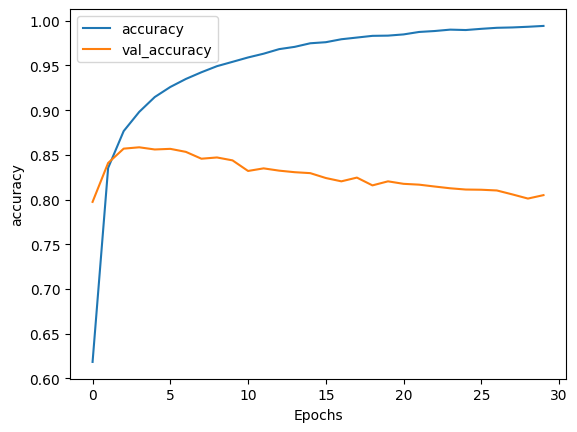

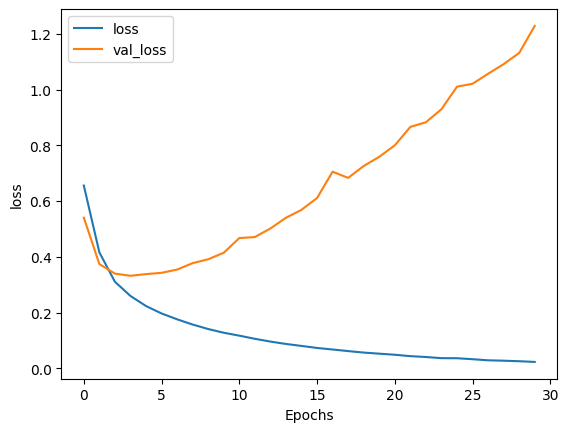

In [12]:
import matplotlib.pyplot as plt
def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string,'val_'+string])
  plt.show()

plot_graphs(history,"accuracy")
plot_graphs(history,"loss")

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
eat your veggies: 9 deliciously different recipes
0


In [14]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [15]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [16]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#example:
sentence =["granny starting to fear spiders in the garden might be real","the weather today is bright and sunny"]
sequences= tokenizer.texts_to_sequences(sentence)
padded= pad_sequences(sequences,maxlen=max_length,padding=padding_type,truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 38ms/step
[[3.7253714e-01]
 [6.6311077e-07]]


In [28]:
!git push --set-upstream origin master

error: src refspec master does not match any
error: failed to push some refs to 'https://github.com/NayanKanaparthi/News-Headlines-sarcasm-detection-NLP.git'
